# 03 - Feature Engineering

**Customer Lifetime Value Prediction**

**Team:** The Starks
- Othmane Zizi (261255341)
- Fares Joni (261254593)
- Tanmay Giri (261272443)

This notebook creates RFM and behavioral features for CLV prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from datetime import datetime, timedelta

# Add src to path
sys.path.append(str(Path('../src').resolve()))
from data_loader import load_processed_data
from features import (
    calculate_rfm_features,
    calculate_behavioral_features,
    create_customer_features,
    split_data_temporal,
    calculate_clv_target
)

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

## 1. Load Cleaned Data

In [2]:
# Load cleaned transaction data
df = load_processed_data('cleaned_retail.csv')
print(f"Loaded {len(df):,} transactions")
print(f"Date range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
df.head()

Loaded 805,549 transactions
Date range: 2009-12-01 to 2011-12-09


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


## 2. Define Observation and Prediction Periods

For CLV prediction, we split the data temporally:
- **Observation Period**: First 12 months - used to calculate features
- **Prediction Period**: Next 6 months - used to calculate CLV target

In [3]:
# Split data into observation and prediction periods
observation_df, prediction_df, obs_end, pred_end = split_data_temporal(
    df,
    date_col='InvoiceDate',
    observation_months=12,
    prediction_months=6
)

print(f"Observation Period: {observation_df['InvoiceDate'].min().date()} to {obs_end.date()}")
print(f"  Transactions: {len(observation_df):,}")
print(f"  Customers: {observation_df['Customer ID'].nunique():,}")

print(f"\nPrediction Period: {obs_end.date()} to {pred_end.date()}")
print(f"  Transactions: {len(prediction_df):,}")
print(f"  Customers: {prediction_df['Customer ID'].nunique():,}")

Observation Period: 2009-12-01 to 2010-12-01
  Transactions: 393,160
  Customers: 4,266

Prediction Period: 2010-12-01 to 2011-06-01
  Transactions: 159,964
  Customers: 2,718


## 3. Calculate RFM Features

**RFM (Recency, Frequency, Monetary)** is a classic customer segmentation framework:
- **Recency**: Days since last purchase (lower = better)
- **Frequency**: Number of purchases (higher = better)
- **Monetary**: Total spend (higher = better)

In [4]:
# Calculate RFM features based on observation period
rfm = calculate_rfm_features(
    observation_df,
    customer_id_col='Customer ID',
    date_col='InvoiceDate',
    amount_col='TotalAmount',
    invoice_col='Invoice',
    reference_date=obs_end
)

print(f"RFM features calculated for {len(rfm):,} customers")
rfm.head(10)

RFM features calculated for 4,266 customers


,Customer ID,Recency,Frequency,Monetary
0,12346,155,11,372.86
1,12347,30,1,611.53
2,12348,64,1,222.16
3,12349,33,3,2671.14
4,12351,1,1,300.93
5,12352,1,2,343.80
6,12353,34,1,317.76
7,12355,193,1,488.21
8,12356,6,3,3562.25
9,12357,14,2,12079.99


In [5]:
# RFM statistics
print("RFM Feature Statistics:")
rfm[['Recency', 'Frequency', 'Monetary']].describe()

RFM Feature Statistics:


,Recency,Frequency,Monetary
count,4266.000000,4266.000000,4266.000000
mean,87.225270,4.321847,1997.216426
std,95.115432,7.763641,8601.786781
min,0.000000,1.000000,2.950000
25%,15.000000,1.000000,307.542500
50%,47.000000,2.000000,689.070000
75%,134.000000,5.000000,1676.380000
max,364.000000,197.000000,321329.740000


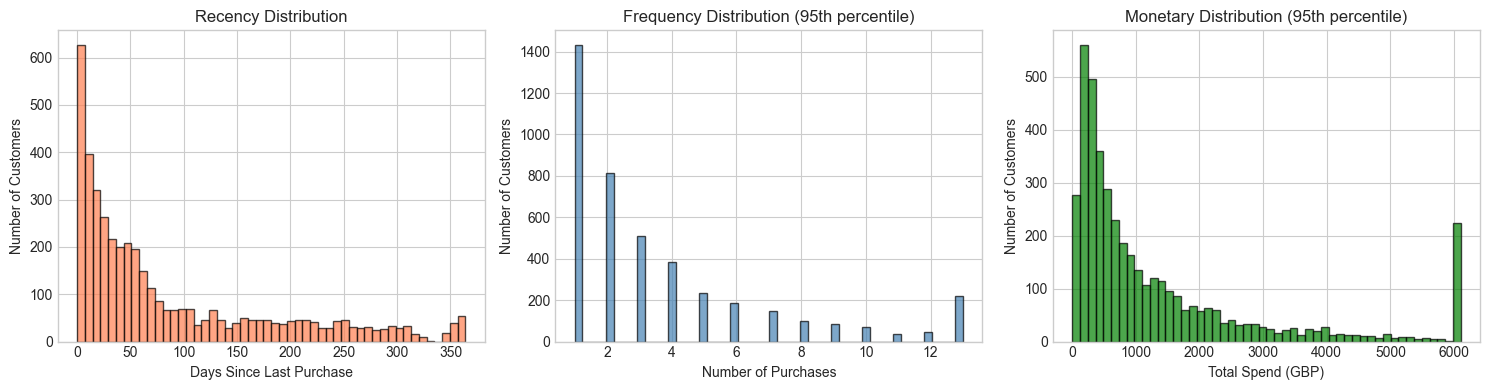

In [6]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recency
axes[0].hist(rfm['Recency'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')

# Frequency
freq_clipped = rfm['Frequency'].clip(upper=rfm['Frequency'].quantile(0.95))
axes[1].hist(freq_clipped, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Frequency Distribution (95th percentile)')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')

# Monetary
monetary_clipped = rfm['Monetary'].clip(upper=rfm['Monetary'].quantile(0.95))
axes[2].hist(monetary_clipped, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Monetary Distribution (95th percentile)')
axes[2].set_xlabel('Total Spend (GBP)')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('../reports/figures/rfm_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Calculate Behavioral Features

Additional features beyond RFM:
- **Tenure**: Days since first purchase
- **AvgTimeBetweenPurchases**: Purchase cadence
- **NumUniqueProducts**: Product diversity
- **AvgBasketSize**: Items per transaction
- **AvgOrderValue**: Spend per transaction

In [7]:
# Calculate behavioral features
behavioral = calculate_behavioral_features(
    observation_df,
    customer_id_col='Customer ID',
    date_col='InvoiceDate',
    amount_col='TotalAmount',
    invoice_col='Invoice',
    quantity_col='Quantity',
    product_col='StockCode',
    reference_date=obs_end
)

print(f"Behavioral features calculated for {len(behavioral):,} customers")
behavioral.head(10)

Behavioral features calculated for 4,266 customers


,Customer ID,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue
0,12346,351,6.000000,26,6.363636,33.896364
1,12347,30,0.000000,40,509.000000,611.530000
2,12348,64,0.000000,20,373.000000,222.160000
3,12349,215,1.782178,90,331.000000,890.380000
4,12351,1,0.000000,21,261.000000,300.930000
5,12352,18,0.941176,18,94.000000,171.900000
6,12353,34,0.000000,20,192.000000,317.760000
7,12355,193,0.000000,22,303.000000,488.210000
8,12356,50,0.518072,68,608.666667,1187.416667
9,12357,14,0.000000,165,1939.500000,6039.995000


In [8]:
# Behavioral feature statistics
print("Behavioral Feature Statistics:")
behavioral.describe()

Behavioral Feature Statistics:


,Customer ID,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue
count,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000
mean,15348.571964,217.867792,3.214827,62.642053,258.194748,381.634564
std,1698.485902,117.329339,11.335602,84.246109,1562.762490,506.528215
min,12346.000000,0.000000,0.000000,1.000000,1.000000,2.950000
25%,13885.000000,113.000000,0.000000,17.000000,90.000000,181.670000
50%,15348.500000,245.000000,1.000000,38.000000,155.000000,290.058750
75%,16833.750000,320.000000,2.942680,78.000000,259.750000,424.876875
max,18287.000000,365.000000,363.000000,1716.000000,87167.000000,11880.840000


## 5. Combine All Features

In [9]:
# Merge RFM and behavioral features
customer_features = rfm.merge(behavioral, on='Customer ID', how='left')

print(f"Total customer features: {len(customer_features):,}")
print(f"\nFeature columns: {customer_features.columns.tolist()}")
customer_features.head(10)

Total customer features: 4,266

Feature columns: ['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'AvgTimeBetweenPurchases', 'NumUniqueProducts', 'AvgBasketSize', 'AvgOrderValue']


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000
5,12352,1,2,343.80,18,0.941176,18,94.000000,171.900000
6,12353,34,1,317.76,34,0.000000,20,192.000000,317.760000
7,12355,193,1,488.21,193,0.000000,22,303.000000,488.210000
8,12356,6,3,3562.25,50,0.518072,68,608.666667,1187.416667
9,12357,14,2,12079.99,14,0.000000,165,1939.500000,6039.995000


## 6. Calculate CLV Target Variable

In [10]:
# Calculate CLV (total spend in prediction period)
clv_target = calculate_clv_target(
    observation_df,
    prediction_df,
    customer_id_col='Customer ID',
    amount_col='TotalAmount'
)

print(f"CLV calculated for {len(clv_target):,} customers")
print(f"\nCLV Statistics:")
print(clv_target['CLV'].describe())

CLV calculated for 4,266 customers

CLV Statistics:
count      4266.000000
mean        748.198280
std        3549.453297
min           0.000000
25%           0.000000
50%           0.000000
75%         586.585000
max      110713.120000
Name: CLV, dtype: float64


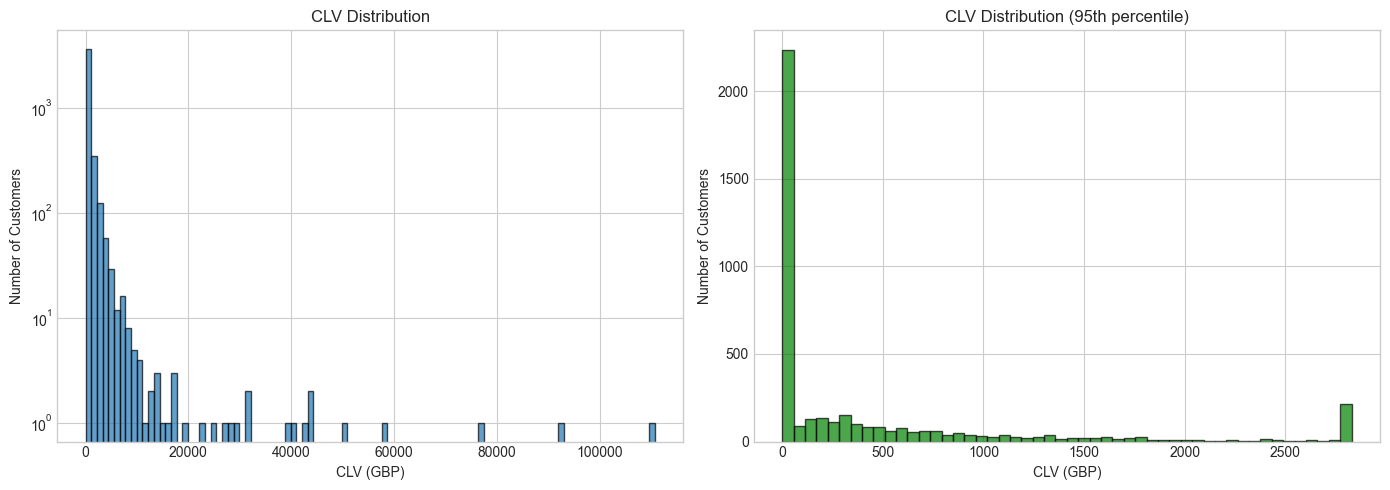


Customers with CLV = 0 (churned): 2,215 (51.9%)


In [11]:
# Visualize CLV distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution (log scale)
axes[0].hist(clv_target['CLV'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('CLV Distribution')
axes[0].set_xlabel('CLV (GBP)')
axes[0].set_ylabel('Number of Customers')
axes[0].set_yscale('log')

# Zoomed in (95th percentile)
clv_clipped = clv_target['CLV'].clip(upper=clv_target['CLV'].quantile(0.95))
axes[1].hist(clv_clipped, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('CLV Distribution (95th percentile)')
axes[1].set_xlabel('CLV (GBP)')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('../reports/figures/clv_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Check churned customers
churned = (clv_target['CLV'] == 0).sum()
print(f"\nCustomers with CLV = 0 (churned): {churned:,} ({churned/len(clv_target)*100:.1f}%)")

## 7. Create Final Dataset

In [12]:
# Merge features with CLV target
final_dataset = customer_features.merge(clv_target, on='Customer ID', how='left')

print(f"Final dataset shape: {final_dataset.shape}")
print(f"\nColumns: {final_dataset.columns.tolist()}")
final_dataset.head(10)

Final dataset shape: (4266, 10)

Columns: ['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'AvgTimeBetweenPurchases', 'NumUniqueProducts', 'AvgBasketSize', 'AvgOrderValue', 'CLV']


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364,77183.60
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000,2535.22
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000,1487.24
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000,0.00
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000,0.00
5,12352,1,2,343.80,18,0.941176,18,94.000000,171.900000,1561.81
6,12353,34,1,317.76,34,0.000000,20,192.000000,317.760000,89.00
7,12355,193,1,488.21,193,0.000000,22,303.000000,488.210000,459.40
8,12356,6,3,3562.25,50,0.518072,68,608.666667,1187.416667,2753.08
9,12357,14,2,12079.99,14,0.000000,165,1939.500000,6039.995000,0.00


In [13]:
# Check for missing values
print("Missing Values:")
missing = final_dataset.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

Missing Values:
No missing values!


In [14]:
# Handle any missing values (fill with 0 for features that can be 0)
final_dataset = final_dataset.fillna(0)

# Final summary statistics
print("\nFinal Dataset Summary:")
final_dataset.describe()


Final Dataset Summary:


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV
count,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000,4266.000000
mean,15348.571964,87.225270,4.321847,1997.216426,217.867792,3.214827,62.642053,258.194748,381.634564,748.198280
std,1698.485902,95.115432,7.763641,8601.786781,117.329339,11.335602,84.246109,1562.762490,506.528215,3549.453297
min,12346.000000,0.000000,1.000000,2.950000,0.000000,0.000000,1.000000,1.000000,2.950000,0.000000
25%,13885.000000,15.000000,1.000000,307.542500,113.000000,0.000000,17.000000,90.000000,181.670000,0.000000
50%,15348.500000,47.000000,2.000000,689.070000,245.000000,1.000000,38.000000,155.000000,290.058750,0.000000
75%,16833.750000,134.000000,5.000000,1676.380000,320.000000,2.942680,78.000000,259.750000,424.876875,586.585000
max,18287.000000,364.000000,197.000000,321329.740000,365.000000,363.000000,1716.000000,87167.000000,11880.840000,110713.120000


## 8. Feature Correlation Analysis

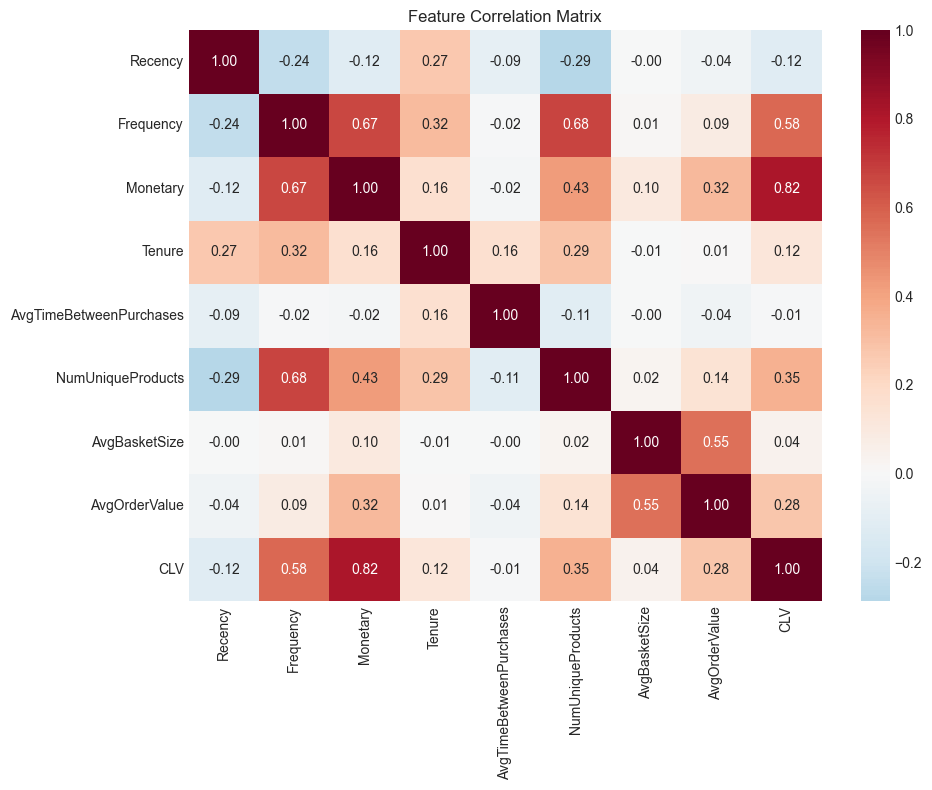

In [15]:
# Correlation matrix
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Tenure', 
                'AvgTimeBetweenPurchases', 'NumUniqueProducts', 
                'AvgBasketSize', 'AvgOrderValue', 'CLV']

corr_matrix = final_dataset[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Correlation with CLV
print("\nCorrelation with CLV (Target):")
clv_corr = final_dataset[feature_cols].corr()['CLV'].drop('CLV').sort_values(ascending=False)
print(clv_corr)


Correlation with CLV (Target):
Monetary                   0.815478
Frequency                  0.576109
NumUniqueProducts          0.353283
AvgOrderValue              0.280242
Tenure                     0.123893
AvgBasketSize              0.043915
AvgTimeBetweenPurchases   -0.013894
Recency                   -0.120860
Name: CLV, dtype: float64


## 9. Save Feature Dataset

In [17]:
# Save the final feature dataset
output_path = Path('../data/processed/customer_features.csv')
final_dataset.to_csv(output_path, index=False)

print(f"Feature dataset saved to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024:.2f} KB")

Feature dataset saved to: ../data/processed/customer_features.csv
File size: 267.81 KB


In [18]:
# Verify saved data
df_verify = pd.read_csv(output_path)
print(f"\nVerification - Loaded shape: {df_verify.shape}")
df_verify.head()


Verification - Loaded shape: (4266, 10)


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364,77183.60
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000,2535.22
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000,1487.24
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000,0.00
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000,0.00


## 10. Feature Engineering Summary

### Features Created:

**RFM Features:**
- `Recency`: Days since last purchase (observation period end)
- `Frequency`: Number of unique invoices/transactions
- `Monetary`: Total spend in observation period

**Behavioral Features:**
- `Tenure`: Days since first purchase
- `AvgTimeBetweenPurchases`: Average days between purchases
- `NumUniqueProducts`: Number of different products purchased
- `AvgBasketSize`: Average items per transaction
- `AvgOrderValue`: Average spend per transaction

**Target Variable:**
- `CLV`: Total spend in prediction period (6 months)

### Key Observations:
- Monetary value has strongest correlation with CLV
- Frequency and NumUniqueProducts also strongly correlated
- Recency shows negative correlation (more recent = higher CLV)

### Next Steps:
- Train ML models to predict CLV
- Perform customer segmentation